### Feed Forward Networks

<p1><center>Creating differentiable computation graphs for classification tasks.</center></p1>
<img src="img/train.gif">

### Create the data

In [1]:
import random
import torch
from torch import nn, optim
import torch.nn.functional as F
import math
import os

In [2]:
%run plot_conf.py

In [3]:
plt_style()

In [4]:
from IPython import display

In [5]:
seed=12345
random.seed(seed)
torch.manual_seed(seed)
N = 1000  # num_samples_per_class
D = 2  # dimensions
C = 3  # num_classes
H = 100  # num_hidden_units

In [6]:
X = torch.zeros(N * C, D)
y = torch.zeros(N * C)

for i in range(C):
    index = 0
    r = torch.linspace(0, 1, N)
    t = torch.linspace(
        i * 2 * math.pi / C,
        (i + 2) * 2 * math.pi / C,
        N
    ) + torch.randn(N) * 0.1
    
    for ix in range(N * i, N * (i + 1)):
        X[ix] = r[index] * torch.FloatTensor((
            math.sin(t[index]), math.cos(t[index])
        ))
        y[ix] = i
        index += 1

print("SHAPES:")
print("-------------------")
print("X:", tuple(X.size()))
print("y:", tuple(y.size()))

SHAPES:
-------------------
X: (3000, 2)
y: (3000,)


In [7]:
def plot_data(X, y, d=.0, auto=False):
    """
    Plot the data.
    """
    plt.clf()
    plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
    plt.axis('square')
    plt.axis((-1.1, 1.1, -1.1, 1.1))
    if auto is True: plt.axis('equal')
#     plt.savefig('spiral{:.2f}.png'.format(d))

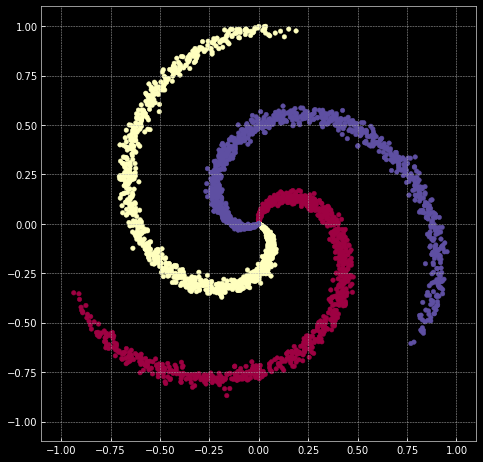

In [8]:
# Create the data
plot_data(X.numpy(), y.numpy())

In [9]:
def plot_model(X, y, model, e=.0, auto=False):
    """
    Plot the model from torch weights.
    """
    
    X = X.numpy()
    y = y.numpy(),
    w1 = torch.transpose(model.fc1.weight.data, 0, 1).numpy()
    b1 = model.fc1.bias.data.numpy()
    w2 = torch.transpose(model.fc2.weight.data, 0, 1).numpy()
    b2 = model.fc2.bias.data.numpy()
    
    h = 0.01

    x_min, x_max = (-1.1, 1.1)
    y_min, y_max = (-1.1, 1.1)
    
    if auto is True:
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = np.dot(np.maximum(0, np.dot(np.c_[xx.ravel(), yy.ravel()], w1) + b1), w2) + b2
    Z = np.argmax(Z, axis=1)
    Z = Z.reshape(xx.shape)
    fig = plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y[0], s=40, cmap=plt.cm.Spectral)
    plt.axis((-1.1, 1.1, -1.1, 1.1))
    plt.axis('square')
    if auto is True:
        plt.axis((xx.min(), xx.max(), yy.min(), yy.max()))
    
#     plt.savefig('train{:03.2f}.png'.format(e))

### Linear model

In [10]:
learning_rate = 1e-3
lambda_l2 = 1e-5

In [11]:
# Linear model
class linear_model(nn.Module):
    """
    Linear model.
    """
    def __init__(self, D_in, H, D_out):
        """
        Initialize weights.
        """
        super(linear_model, self).__init__()
        self.fc1 = nn.Linear(D_in, H)
        self.fc2 = nn.Linear(H, D_out)

    def forward(self, x):
        """
        Forward pass.
        """
        z = self.fc1(x)
        z = self.fc2(z)
        return z

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
# nn package to create our linear model
# each Linear module has a weight and bias
model = linear_model(D, H, C)
model.to(device) #Convert to CUDA

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
criterion = torch.nn.CrossEntropyLoss()

# we use the optim package to apply
# stochastic gradient descent for our parameter updates
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# We convert our inputs and targets to Variables
# so we can use automatic differentiation but we 
# use require_grad=False b/c we don't want the gradients
# to alter these values.
input_X = torch.tensor(X, requires_grad=False, dtype=torch.float32)
y_true = torch.tensor(y, requires_grad=False, dtype=torch.long)

# Training
for t in range(1000):
    
    # Feed forward to get the logits
    y_pred = model(input_X)
    
    # Compute the loss and accuracy
    loss = criterion(y_pred, y_true)
    score, predicted = torch.max(y_pred, 1)
    acc = (y_true == predicted).sum().float() / len(y_true)
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), acc))
    display.clear_output(wait=True)
    
    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()
    
    # Backward pass to compute the gradient
    # of loss w.r.t our learnable params. 
    loss.backward()
    
    # Update params
    optimizer.step()

[EPOCH]: 999, [LOSS]: 0.854275, [ACCURACY]: 0.503


In [14]:
# Plot trained model
print(model)

linear_model(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=3, bias=True)
)


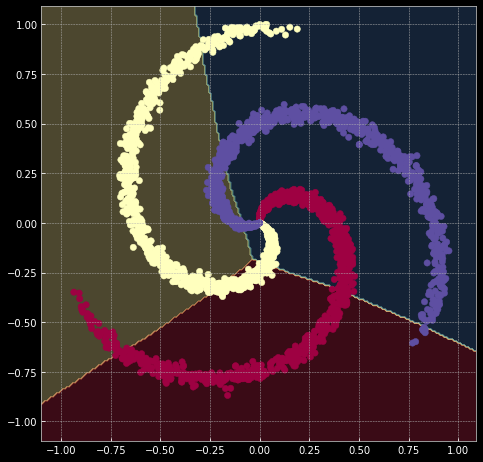

In [15]:
plot_model(X, y, model)

### Two-layered network

In [16]:
learning_rate = 1e-3
lambda_l2 = 1e-5

In [17]:
# NN model
class two_layer_network(nn.Module):
    """
    NN model.
    """
    def __init__(self, D_in, H, D_out):
        """
        Initialize weights.
        """
        super(two_layer_network, self).__init__()
        self.fc1 = nn.Linear(D_in, H)
        self.fc2 = nn.Linear(H, D_out)

    def forward(self, x):
        """
        Forward pass.
        """
        z = F.relu(self.fc1(x))
        z = self.fc2(z)
        return z

In [18]:
# nn package to create our linear model
# each Linear module has a weight and bias
model = two_layer_network(D, H, C)
model.to(device)

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
criterion = torch.nn.CrossEntropyLoss()

# we use the optim package to apply
# ADAM for our parameter updates
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# We convert our inputs and targest to Variables
# so we can use automatic differentiation but we 
# use require_grad=False b/c we don't want the gradients
# to alter these values.
input_X = torch.tensor(X, requires_grad=False, dtype=torch.float32)
y_true = torch.tensor(y, requires_grad=False, dtype=torch.long)

# e = 1.  # plotting purpose

# Training
for t in range(1000):
    
    # Feed forward to get the logits
    y_pred = model(input_X)
    
    # Compute the loss and accuracy
    loss = criterion(y_pred, y_true)
    score, predicted = torch.max(y_pred, 1)
    acc = (y_true == predicted).sum().float() / len(y_true)
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), acc))
    display.clear_output(wait=True)
    
    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()
    
    # Backward pass to compute the gradient
    # of loss w.r.t our learnable params. 
    loss.backward()
    
    # Update params
    optimizer.step()
    
#    # Plot some progress
#     if t % math.ceil(e) == 0:
#         plot_model(X, y, model, e)
#         e *= 1.5

#! convert -delay 20 -crop 500x475+330+50 +repage $(gls -1v train*) train.gif

[EPOCH]: 999, [LOSS]: 0.162188, [ACCURACY]: 0.956


two_layer_network(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=3, bias=True)
)


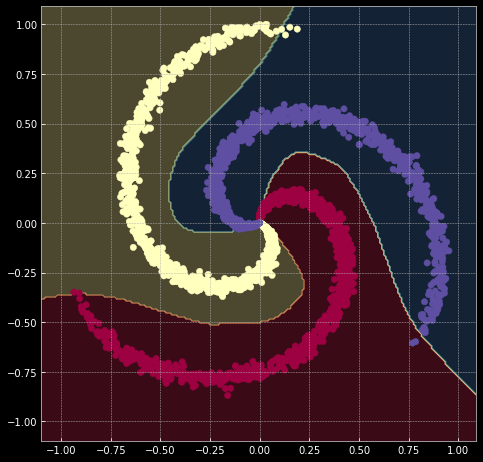

In [19]:
# Plot trained model
print(model)
plot_model(X, y, model)